# Linear Regression Using TensorFlow

We will be using [Galton's Height Data](http://www.randomservices.org/random/data/Galton.html) for our coding session to build something cool using linear regression. First we'll get the data and do some pre-processing. 

If you're a novice to `tf`, to follow the below code, I strongly recommend a beginner tutorial on TensorFlow. You can get my tutorial [here.](https://github.com/sleebapaul/hello_tensorflow/blob/master/hello_tensorflow.ipynb)

In [1]:
# import the required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# read the data set and show it's head

df_path = "Datasets/Galton.txt"
df = pd.read_csv(df_path, header= 0, sep="\t")
print (df.head())

  Family  Father  Mother Gender  Height  Kids
0      1    78.5    67.0      M    73.2     4
1      1    78.5    67.0      F    69.2     4
2      1    78.5    67.0      F    69.0     4
3      1    78.5    67.0      F    69.0     4
4      2    75.5    66.5      M    73.5     4


We are interested in Heights of Father and Mother for our application. It's unit is in inches. We'll convert it into centimeters for our use. Again, there are multiple records for each set of parents. This will be squeezed to single records. 

In [3]:
# select the required columns
df_new = df.loc[:, ['Father','Mother']]
df_new.head()

,Father,Mother
0,78.5,67.0
1,78.5,67.0
2,78.5,67.0
3,78.5,67.0
4,75.5,66.5


In [4]:
# remove duplicates 
df_new = df_new.drop_duplicates(keep='first').reset_index(drop=True)
df_new.head()

,Father,Mother
0,78.5,67.0
1,75.5,66.5
2,75.0,64.0
3,75.0,58.5
4,74.0,68.0


Let's rename the column names and plot it.

In [5]:
df_new.columns = ['father_height', 'mother_height']
df_new.head()

,father_height,mother_height
0,78.5,67.0
1,75.5,66.5
2,75.0,64.0
3,75.0,58.5
4,74.0,68.0


In [6]:
# convert inches to cms
df_new = 2.54 * df_new
df_new.head()

,father_height,mother_height
0,199.39,170.18
1,191.77,168.91
2,190.50,162.56
3,190.50,148.59
4,187.96,172.72


In [7]:
x = df_new.father_height.as_matrix()
y = df_new.mother_height.as_matrix()

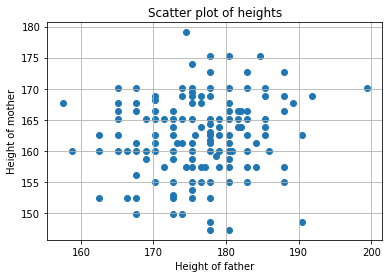

In [9]:
plt.scatter(x, y) # let's plot the distribution

plt.xlabel('Height of father') # xlabel
plt.ylabel('Height of mother')# y label
plt.title('Scatter plot of heights') # title of plot
plt.grid(True) # grid on plot surface
plt.show()

If you observe the data keenly, all we can say that it has a positive growth. We don't know if it is a linear relationship or not. But what we're going to attempt, is to get the best fitted linear line for this data.

But, what we're going build with this data? ;) 

We are going to build a **Height predictor of Partner** given your height. Cool?   

For bachelors and bachelorettes, it would be beneficial. For people who are already married, well, nothing can be done, still you can cross check :P 

To calculate my future partner's height, the jargon would be, 

- Height of mother will be my dependent variable
- Height of father will be my independent variable

Additionally, we are going to [mean normalize](https://stats.stackexchange.com/questions/41704/how-and-why-do-normalization-and-feature-scaling-work) our dataset since values in a larger interval may cause converging issues to our optimizer.   

$$Mean\ Normalization\ of\ X = \frac{X - \mu}{S}$$

where $\mu$ is the mean of the distribution and $S\ =\ max(X)\ -\ min(X)$ 

This is not going to change the distribution of our dataset but only change the magnitude. I'll demostrate you that. 

In [10]:
def mean_normalization(X):
    """
    Mean normalize the distribution
    """
    mean = np.mean(X)
    min_val = np.min(X)
    max_val = np.max(X)
    mean_norm = (X - mean)/(max_val - min_val)
    return mean_norm

In [11]:
print("x Before normalization")
print(x[:15])
print("x After normalization")
x_norm = mean_normalization(x)
print(x_norm[:15])

x Before normalization
[ 199.39  191.77  190.5   190.5   187.96  187.96  189.23  187.96  187.96
  187.96  185.42  185.42  185.42  185.42  185.42]
x After normalization
[ 0.54949495  0.36767677  0.33737374  0.33737374  0.27676768  0.27676768
  0.30707071  0.27676768  0.27676768  0.27676768  0.21616162  0.21616162
  0.21616162  0.21616162  0.21616162]


In [12]:
print("y Before normalization")
print(y[:15])
print("y After normalization")
y_norm = mean_normalization(y)
print(y_norm[:15])

y Before normalization
[ 170.18  168.91  162.56  148.59  172.72  168.91  167.64  166.37  157.48
  154.94  170.18  168.91  165.1   163.83  162.56]
y After normalization
[ 0.24469565  0.20469565  0.00469565 -0.43530435  0.32469565  0.20469565
  0.16469565  0.12469565 -0.15530435 -0.23530435  0.24469565  0.20469565
  0.08469565  0.04469565  0.00469565]


Let's plot both distributions before and after mean normalization. 

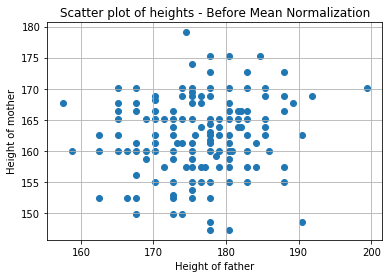

In [13]:
# let's plot the graph before normalization
plt.scatter(x, y) 

plt.xlabel('Height of father') # xlabel
plt.ylabel('Height of mother')# y label
plt.title('Scatter plot of heights - Before Mean Normalization') # title of plot
plt.grid(True) # grid on plot surface
plt.show()

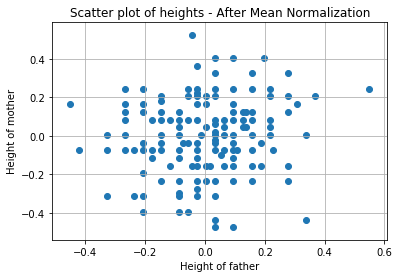

In [15]:
# let's plot the graph after normalization
plt.scatter(x_norm, y_norm) 

plt.xlabel('Height of father') # xlabel
plt.ylabel('Height of mother')# y label
plt.title('Scatter plot of heights - After Mean Normalization') # title of plot
plt.grid(True) # grid on plot surface
plt.show()

Now you can understand that, Mean Normalization only changes (check the axis ranges) the magnitude never the distribution of data. You should definitely try optimizing the data without normalizing it and watch the behaviour of our optimizer.  

In [16]:
# Without Mean Normalization
# X_train = x
# Y_train = y

# With normalization

X_train = x_norm
Y_train = y_norm

# Here, if you missed, our training data is represented as numpy arrays which are essentially matrices. See how easily
# we can use them for our further computation. 

## Optimization

In [17]:
def optimizer(X_train, Y_train, learning_rate=0.01, training_epochs=10000):
    
    # Step 1: create placeholders for input X (father_height) and label Y (mother_height)

    X = tf.placeholder(tf.float32, name="X")
    Y = tf.placeholder(tf.float32, name="Y")


    # Step 2: create slope and bias, initialized to 0

    a = tf.Variable(0.0, name="slope")
    b = tf.Variable(0.0, name="bias")


    # Step 3: construct model to predict Y (height of mother/partner) from X (height of father)
    # y_pred = a * x + b
    Y_predicted = X * a + b

    # Step 4: use the square error as the loss function
    # we know the loss function (y_true - y_pred)^2
    # don't miss the application of vectorization here
    loss = tf.square(Y - Y_predicted, name="loss")

    # Step 5: scaling it to entire data set
    # tf.reduce_mean will calculate the averaged error for us

    cost = tf.reduce_mean(loss) # this is out cost function

    # Step 6: the one line code of our optimization technique
    # here we've used Gradient Descent and learning rate is a parameter 
    # optimizer minimize cost we defined above. 

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)


    with tf.Session() as sess:
        
    # Step 7: initialize the all necessary variables, in this case, w and b
        sess.run(tf.global_variables_initializer())
        cost_list = []
        a_value = []
        b_value = []
        iterations = []
    # Step 8: train the model
        for i in range(training_epochs+1): # run desired no. of epochs
            # Session runs train_op to minimize loss
            _, loss_value = sess.run([optimizer, cost], feed_dict={X: X_train, Y:Y_train}) 
            if i%1000 == 0:
                # all these values changes at end of one epoch
                # this is the recurring process we've discussed in theory part
                cost_list.append(loss_value) 
                a_value.append(sess.run(a))
                b_value.append(sess.run(b))
                iterations.append(i)
    return cost_list, a_value, b_value, iterations

In [18]:
# Training 
cost_list, a_value, b_value, iterations = optimizer(X_train, Y_train, learning_rate=0.01, training_epochs=10000)

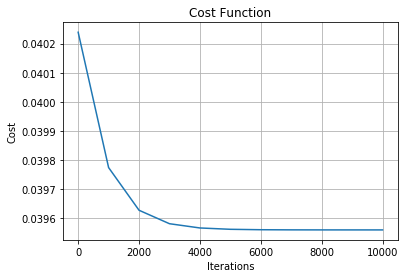

In [19]:
# Let's plot the cost to iterations to check if the cost is reducing as we expect or this whole tutorial was a lie :D 

plt.plot(iterations, cost_list) # let's plot the graph

plt.xlabel('Iterations') # xlabel
plt.ylabel('Cost')# y label
plt.title('Cost Function') # title of plot
plt.grid(True) # grid on plot surface
plt.show()

Hurray !!! Our boy is indeed reaching towards the valley. Let's have a look at our $a_{opt}$ and $b_{opt}$.

In [20]:
a_opt = a_value[-1]
b_opt = b_value[-1]
print("Optimum slope value after 10000 epochs: {}".format(a_opt))
print("Optimum Y intercept value after 10000 epochs: {}".format(b_opt))

Optimum slope value after 10000 epochs: 0.15296973288059235
Optimum Y intercept value after 10000 epochs: 1.8032759729891268e-09


Let's plot the fit on our data and check if it is doing justice. 

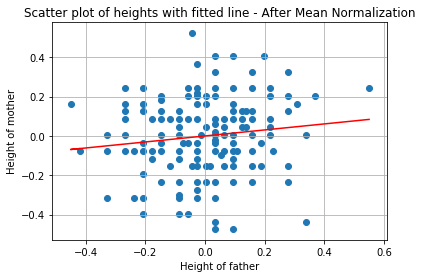

In [21]:
fig, ax = plt.subplots()
ax.plot(X_train, a_opt * X_train + b_opt, color='red')
ax.scatter(X_train, Y_train)
plt.xlabel('Height of father') # xlabel
plt.ylabel('Height of mother')# y label
plt.title('Scatter plot of heights with fitted line - After Mean Normalization') # title of plot
plt.grid(True) # grid on plot surface
plt.show()
plt.show()

Now, I'm so excited to find out my partner's expected height. WOO-HOO !!!

For that we need one a conversion function which can deal with the mean normalization.

In [22]:
def predict(my_height, X, a_opt, b_opt):
    """
    Predict the height of the partner 
    """
    mean = np.mean(X)
    min_val = np.min(X)
    max_val = np.max(X)
    mean_norm_my_height = (my_height - mean)/(max_val - min_val)
    mean_norm_partner_height = a_opt * mean_norm_my_height + b_opt
    partner_height = (max_val - min_val) * mean_norm_partner_height + mean
    return partner_height

In [25]:
my_height = 168.0
print("My height in cms: {}".format(my_height))
print("My partner's height in cms: {}".format(predict(my_height, x, a_opt, b_opt)))

My height in cms: 168.0
My partner's height in cms: 175.08173779553826


Ouch ! that hurts my male chauvinist ego. :D :D :D But according to the data, I should get a taller women :D 
Try yours ;) 

Jokes apart, these results may not reflect real life all the time but Linear Regression is made use of, in many practical conditions. Check some of them [here](https://www.southampton.ac.uk/passs/confidence_in_the_police/multivariate_analysis/multiple_linear_regression.page), [here](http://adsabs.harvard.edu/abs/1990ApJ...364..104I) and [here](http://www.investopedia.com/articles/trading/09/linear-regression-time-price.asp) and [here](http://www.dummies.com/personal-finance/investing/technical-analysis/how-to-use-a-linear-regression-to-identify-market-trends/).

Well, that's it. We've learned to code Linear Regression using TensorFlow. On closing notes, I would like to mention two or three concepts breifly here. 

1. Learning rate
    - We know that learning rate is the step size our optimization algorithm takes at once. So what will happen if we take a small step? It'll consume a lot of time to reach the valley. What about a big step? We may miss our optimum value. So we shoud tune learning rate considering this trade-off. Learn more about learning rate [here.](https://medium.com/towards-data-science/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
    - Try optimizing on different values of learning rate and plot the cost graph. You'll get more intuitions.
2. Try changing the initial values of our parameters, as this can significantly affect the way Gradient Descent algorithm works.

---------------------------------------

```
Baby, what is your height? ;)
You don't know that? :@ It's 152.
Okay :|
```
Outliers are always special :D :D 
I hope you had a great time :) 
Happy learning !